# FakeRealNewsClassifier

In [2]:
import pandas as pd
import numpy as np

In [3]:
df=pd.read_csv("../input/source-based-news-classification/news_articles.csv")
df.head(3)

,author,published,title,text,language,site_url,main_img_url,type,label,title_without_stopwords,text_without_stopwords,hasImage
0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...,1.0
1,reasoning with facts,2016-10-29T08:47:11.259+03:00,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,1.0
2,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,breaking weiner cooperating with fbi on hillar...,red state \nfox news sunday reported this mor...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,breaking weiner cooperating fbi hillary email ...,red state fox news sunday reported morning ant...,1.0


In [4]:
df["type"].unique()

array(['bias', 'conspiracy', 'fake', 'bs', 'satire', 'hate', 'junksci',
       'state', nan], dtype=object)

In [5]:
df.shape

(2096, 12)

In [6]:
df.isnull().sum()

author                      0
published                   0
title                       0
text                       46
language                    1
site_url                    1
main_img_url                1
type                        1
label                       1
title_without_stopwords     2
text_without_stopwords     50
hasImage                    1
dtype: int64

In [7]:
df=df.dropna() #Drop Nan Values

In [8]:
df.reset_index(inplace=True)

Fake    1291
Real     754
Name: label, dtype: int64


<AxesSubplot:xlabel='label', ylabel='count'>

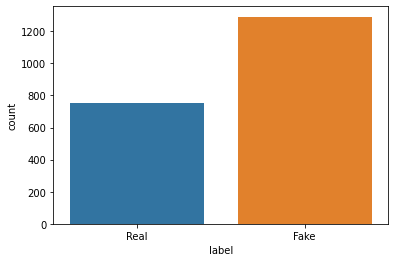

In [9]:
import seaborn as sns
print(df.label.value_counts())
sns.countplot(x=df["label"])

In [10]:
df["label"]=df.label.map({'Real':1,'Fake':0})
print(df.label.unique())

[1 0]


In [11]:
from keras.layers import Embedding, LSTM, Dense
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.models import Sequential

In [12]:
y=df['label']
X = df['title_without_stopwords'] + ' ' + df['text_without_stopwords']

In [13]:
X = X.astype(str)

#### one hot representation

In [14]:
voc_size=10000
ohr=[one_hot(words,voc_size)for words in X]

#### Embedding Representation

In [15]:
sent_length=120
emb_rep=pad_sequences(ohr,padding='pre',maxlen=sent_length)
print(emb_rep)

[[   0    0    0 ... 2767 1795 9953]
 [8634 4394 1981 ... 8331 6954 9953]
 [8148 3748 8307 ... 7174 4705 9953]
 ...
 [   0    0    0 ...  523 3307 7309]
 [1150 3063 6528 ... 4957 4986 1845]
 [   0    0    0 ...  519 6077 7816]]


In [16]:
X=np.array(emb_rep)
y=np.array(y)

#### LSTM

In [17]:
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss="binary_crossentropy",optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 40)           400000    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 456,501
Trainable params: 456,501
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [19]:
# fit model
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
22/22 [==============================] - 6s 195ms/step - loss: 0.6814 - accuracy: 0.6040 - val_loss: 0.6427 - val_accuracy: 0.6548
Epoch 2/10
22/22 [==============================] - 4s 164ms/step - loss: 0.6255 - accuracy: 0.6208 - val_loss: 0.5617 - val_accuracy: 0.6770
Epoch 3/10
22/22 [==============================] - 3s 155ms/step - loss: 0.3515 - accuracy: 0.8582 - val_loss: 0.5409 - val_accuracy: 0.6963
Epoch 4/10
22/22 [==============================] - 3s 154ms/step - loss: 0.2653 - accuracy: 0.9432 - val_loss: 0.6960 - val_accuracy: 0.7170
Epoch 5/10
22/22 [==============================] - 3s 154ms/step - loss: 0.0637 - accuracy: 0.9875 - val_loss: 0.7737 - val_accuracy: 0.7126
Epoch 6/10
22/22 [==============================] - 3s 154ms/step - loss: 0.0416 - accuracy: 0.9906 - val_loss: 0.7903 - val_accuracy: 0.6978
Epoch 7/10
22/22 [==============================] - 3s 154ms/step - loss: 0.0279 - accuracy: 0.9922 - val_loss: 0.9493 - val_accuracy: 0.7007
Epoch 

In [20]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score

# Predicting from test data
y_pred=model.predict_classes(X_test)

#Creating confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
print("confusion_matrix: \n",cm)
print("accuracy_score: ",metrics.accuracy_score(y_test,y_pred))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


confusion_matrix: 
 [[325 117]
 [ 86 147]]
accuracy_score:  0.6992592592592592


#### Bidirectional LSTM Model

In [21]:
# Creating bidirectional lstm model
from tensorflow.keras.layers import Bidirectional, Dropout
embedding_vector_features=40
model1=Sequential()
model1.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model1.add(Bidirectional(LSTM(100))) # Bidirectional LSTM layer
model1.add(Dropout(0.3))
model1.add(Dense(1,activation='sigmoid'))
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 40)           400000    
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               112800    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 513,001
Trainable params: 513,001
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
# Fitting the model
model1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
22/22 [==============================] - 9s 247ms/step - loss: 0.6789 - accuracy: 0.6066 - val_loss: 0.6451 - val_accuracy: 0.6548
Epoch 2/10
22/22 [==============================] - 5s 208ms/step - loss: 0.6410 - accuracy: 0.6251 - val_loss: 0.5887 - val_accuracy: 0.6681
Epoch 3/10
22/22 [==============================] - 5s 209ms/step - loss: 0.5767 - accuracy: 0.7427 - val_loss: 0.5900 - val_accuracy: 0.7378
Epoch 4/10
22/22 [==============================] - 4s 205ms/step - loss: 0.4742 - accuracy: 0.9013 - val_loss: 0.5277 - val_accuracy: 0.7126
Epoch 5/10
22/22 [==============================] - 4s 205ms/step - loss: 0.2789 - accuracy: 0.9348 - val_loss: 0.5564 - val_accuracy: 0.7333
Epoch 6/10
22/22 [==============================] - 5s 211ms/step - loss: 0.1067 - accuracy: 0.9731 - val_loss: 0.5628 - val_accuracy: 0.7289
Epoch 7/10
22/22 [==============================] - 5s 221ms/step - loss: 0.0612 - accuracy: 0.9908 - val_loss: 0.7715 - val_accuracy: 0.7081
Epoch 

In [23]:
y_pred1=model1.predict_classes(X_test)

#Confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred1)
cm

array([[368,  74],
       [115, 118]])

In [24]:
#Calculating Accuracy score
accuracy_score(y_test,y_pred1)

0.72

In [25]:
y_pred1=model1.predict_classes(X)
df["prediction"]=y_pred1

In [26]:
submission=df[["label","prediction"]]
submission

,label,prediction
0,1,1
1,1,1
2,1,0
3,1,1
4,1,1
...,...,...
2040,1,1
2041,1,1
2042,1,1
2043,1,1


In [27]:
submission.to_csv("submission.csv")